# v21 Data Preparation

This notebook processes term pairs collected from `00_data_ingestion.ipynb` and creates the training dataset.

## v21 Key Changes

| Feature | v19 | v21 |
|---------|-----|-----|
| Base Model | xlm-roberta-large | **skt/A.X-Encoder-base** |
| Vocab Size | 250,002 | **50,000** |
| Korean Support | Multilingual | **Korean-optimized** |

## Input/Output

- **Input**: `term_pairs.jsonl` (1:1 Korean-English pairs)
- **Output**: `term_mappings.jsonl` (1:N Korean to multi-target mappings with similarity scores)

## Process

1. Load term pairs from `00_data_ingestion.ipynb` output
2. Group by Korean source term
3. Calculate similarity scores using BGE-M3 embeddings
4. Save as 1:N format for training

In [1]:
import sys
from pathlib import Path

def find_project_root():
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists() or (parent / "src").exists():
            return parent
    return Path.cwd().parent.parent

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))
print(f"Project root: {PROJECT_ROOT}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train


In [2]:
import json
from collections import defaultdict
from typing import Dict, List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from sentence_transformers import SentenceTransformer

DATA_DIR = PROJECT_ROOT / "dataset" / "v21_skt_encoder"
print(f"Data directory: {DATA_DIR}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Data directory: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v21_skt_encoder
PyTorch: 2.10.0.dev20251109+cu130
CUDA available: True


## Configuration

In [3]:
CONFIG = {
    # Embedding model for similarity calculation
    "embedding_model": "BAAI/bge-m3",  # Best multilingual model
    "batch_size": 128,
    
    # Similarity thresholds
    "min_similarity": 0.3,  # Minimum similarity to keep
    "max_targets_per_source": 15,  # Max English targets per Korean term
    
    # Source-based similarity defaults (when embedding fails)
    "default_sim_it": 0.95,  # IT terminology (high quality)
    "default_sim_muse": 0.90,  # MUSE dictionary
    "default_sim_wikidata": 0.85,  # Wikidata
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Configuration:
  embedding_model: BAAI/bge-m3
  batch_size: 128
  min_similarity: 0.3
  max_targets_per_source: 15
  default_sim_it: 0.95
  default_sim_muse: 0.9
  default_sim_wikidata: 0.85


## 1. Load Term Pairs

In [4]:
term_pairs_path = DATA_DIR / "term_pairs.jsonl"

if not term_pairs_path.exists():
    raise FileNotFoundError(
        f"term_pairs.jsonl not found at {term_pairs_path}\n"
        "Please run 00_data_ingestion.ipynb first."
    )

print(f"Loading term pairs from: {term_pairs_path}")

term_pairs = []
with open(term_pairs_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Loading"):
        term_pairs.append(json.loads(line.strip()))

print(f"\nLoaded {len(term_pairs):,} term pairs")

# Statistics
sources = defaultdict(int)
for p in term_pairs:
    sources[p.get("source", "unknown")] += 1

print("\nBy source:")
for src, cnt in sorted(sources.items(), key=lambda x: -x[1]):
    print(f"  {src}: {cnt:,} ({cnt/len(term_pairs)*100:.1f}%)")

Loading term pairs from: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v21_skt_encoder/term_pairs.jsonl


Loading: 0it [00:00, ?it/s]


Loaded 69,897 term pairs

By source:
  wikidata: 49,227 (70.4%)
  muse: 20,539 (29.4%)
  it_terminology: 131 (0.2%)


## 2. Group by Korean Term

In [5]:
# Group English terms by Korean source
ko_to_en: Dict[str, List[Tuple[str, str]]] = defaultdict(list)  # ko -> [(en, source), ...]

for pair in term_pairs:
    ko = pair["ko"]
    en = pair["en"].lower()
    source = pair.get("source", "unknown")
    
    # Deduplicate within same Korean term
    if (en, source) not in ko_to_en[ko]:
        ko_to_en[ko].append((en, source))

print(f"Unique Korean terms: {len(ko_to_en):,}")

# Distribution of English targets per Korean
target_counts = [len(v) for v in ko_to_en.values()]
print(f"\nEnglish targets per Korean:")
print(f"  Min: {min(target_counts)}")
print(f"  Max: {max(target_counts)}")
print(f"  Mean: {np.mean(target_counts):.2f}")
print(f"  Median: {np.median(target_counts):.1f}")

Unique Korean terms: 62,502

English targets per Korean:
  Min: 1
  Max: 7
  Mean: 1.12
  Median: 1.0


## 3. Load Embedding Model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

print(f"\nLoading embedding model: {CONFIG['embedding_model']}...")
embed_model = SentenceTransformer(CONFIG["embedding_model"])
embed_model = embed_model.to(device)

print(f"Model loaded successfully!")
print(f"Embedding dimension: {embed_model.get_sentence_embedding_dimension()}")

Device: cuda

Loading embedding model: BAAI/bge-m3...


/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


Model loaded successfully!
Embedding dimension: 1024


## 4. Calculate Similarity Scores

In [7]:
def get_default_similarity(source: str) -> float:
    """Get default similarity based on source."""
    if source == "it_terminology":
        return CONFIG["default_sim_it"]
    elif source == "muse":
        return CONFIG["default_sim_muse"]
    else:
        return CONFIG["default_sim_wikidata"]


def calculate_similarities_batch(
    ko_terms: List[str],
    en_targets_list: List[List[Tuple[str, str]]],
    model: SentenceTransformer,
    batch_size: int = 128,
) -> Dict[str, List[Tuple[str, float]]]:
    """Calculate cosine similarities between Korean terms and their English targets.
    
    Args:
        ko_terms: List of Korean source terms
        en_targets_list: List of [(en_term, source), ...] for each Korean term
        model: SentenceTransformer model
        batch_size: Batch size for encoding
    
    Returns:
        Dict mapping Korean term to [(en_term, similarity), ...]
    """
    results = {}
    
    # Collect all texts to encode
    all_texts = list(ko_terms)
    ko_indices = {ko: i for i, ko in enumerate(ko_terms)}
    
    en_start_idx = len(ko_terms)
    en_indices = {}  # (ko, en) -> index in all_texts
    
    for ko, en_list in zip(ko_terms, en_targets_list):
        for en, source in en_list:
            if en not in [t for t in all_texts[en_start_idx:]]:
                en_indices[(ko, en)] = len(all_texts)
                all_texts.append(en)
            else:
                # Find existing index
                for i, t in enumerate(all_texts[en_start_idx:], start=en_start_idx):
                    if t == en:
                        en_indices[(ko, en)] = i
                        break
    
    print(f"Encoding {len(all_texts):,} texts...")
    
    # Encode all texts
    embeddings = model.encode(
        all_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        normalize_embeddings=True,
        convert_to_numpy=True,
    )
    
    # Calculate similarities
    print("Calculating similarities...")
    for ko, en_list in tqdm(zip(ko_terms, en_targets_list), total=len(ko_terms)):
        ko_idx = ko_indices[ko]
        ko_emb = embeddings[ko_idx]
        
        term_sims = []
        for en, source in en_list:
            en_idx = en_indices.get((ko, en))
            if en_idx is not None:
                en_emb = embeddings[en_idx]
                # Cosine similarity (embeddings are normalized)
                sim = float(np.dot(ko_emb, en_emb))
            else:
                # Fallback to default
                sim = get_default_similarity(source)
            
            # Apply minimum threshold
            if sim >= CONFIG["min_similarity"]:
                term_sims.append((en, sim))
        
        # Sort by similarity and limit
        term_sims.sort(key=lambda x: -x[1])
        results[ko] = term_sims[:CONFIG["max_targets_per_source"]]
    
    return results

In [8]:
# Calculate similarities
ko_list = list(ko_to_en.keys())
en_list = [ko_to_en[ko] for ko in ko_list]

print(f"Processing {len(ko_list):,} Korean terms...")

term_mappings = calculate_similarities_batch(
    ko_list,
    en_list,
    embed_model,
    batch_size=CONFIG["batch_size"],
)

Processing 62,502 Korean terms...
Encoding 127,257 texts...


Batches:   0%|          | 0/995 [00:00<?, ?it/s]

Calculating similarities...


  0%|          | 0/62502 [00:00<?, ?it/s]

## 5. Analyze Results

In [9]:
# Filter out empty mappings
term_mappings = {k: v for k, v in term_mappings.items() if v}

print("=" * 70)
print("PROCESSING RESULTS")
print("=" * 70)

print(f"\nKorean terms with targets: {len(term_mappings):,}")
total_targets = sum(len(v) for v in term_mappings.values())
print(f"Total target terms: {total_targets:,}")

# Statistics
target_counts = [len(v) for v in term_mappings.values()]
all_sims = [s for v in term_mappings.values() for _, s in v]

print(f"\nTargets per Korean term:")
print(f"  Min: {min(target_counts)}")
print(f"  Max: {max(target_counts)}")
print(f"  Mean: {np.mean(target_counts):.2f}")
print(f"  Median: {np.median(target_counts):.1f}")

print(f"\nSimilarity scores:")
print(f"  Min: {min(all_sims):.4f}")
print(f"  Max: {max(all_sims):.4f}")
print(f"  Mean: {np.mean(all_sims):.4f}")
print(f"  Median: {np.median(all_sims):.4f}")

PROCESSING RESULTS

Korean terms with targets: 62,291
Total target terms: 69,667

Targets per Korean term:
  Min: 1
  Max: 7
  Mean: 1.12
  Median: 1.0

Similarity scores:
  Min: 0.3001
  Max: 0.9720
  Mean: 0.6578
  Median: 0.6630


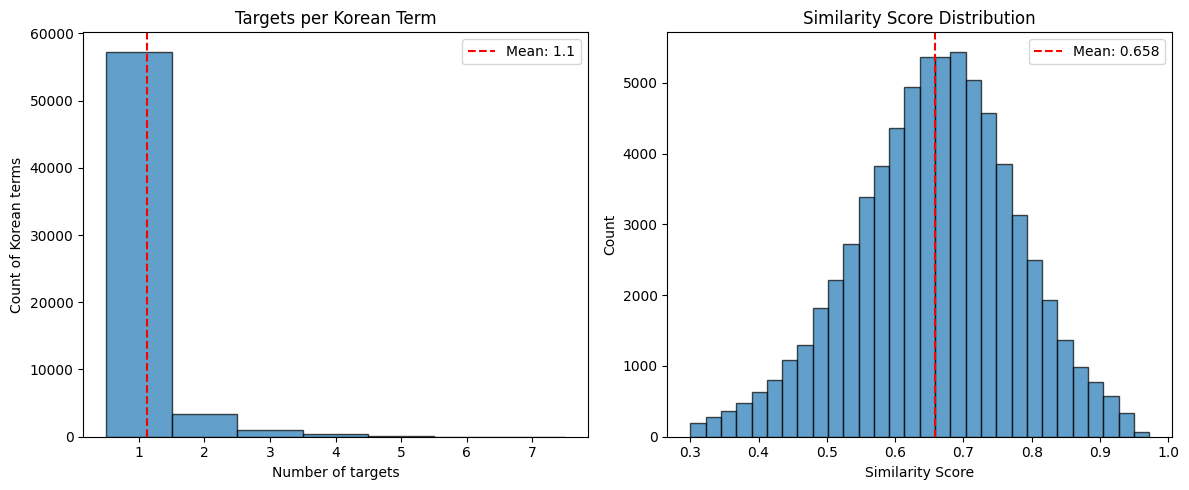

In [10]:
# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Target count distribution
ax1 = axes[0]
ax1.hist(target_counts, bins=range(1, max(target_counts) + 2), 
         edgecolor='black', alpha=0.7, align='left')
ax1.set_xlabel('Number of targets')
ax1.set_ylabel('Count of Korean terms')
ax1.set_title('Targets per Korean Term')
ax1.axvline(np.mean(target_counts), color='red', linestyle='--', 
            label=f'Mean: {np.mean(target_counts):.1f}')
ax1.legend()

# Similarity score distribution
ax2 = axes[1]
ax2.hist(all_sims, bins=30, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Similarity Score')
ax2.set_ylabel('Count')
ax2.set_title('Similarity Score Distribution')
ax2.axvline(np.mean(all_sims), color='red', linestyle='--',
            label=f'Mean: {np.mean(all_sims):.3f}')
ax2.legend()

plt.tight_layout()
plt.show()

In [11]:
# Sample mappings
print("=" * 70)
print("SAMPLE MAPPINGS")
print("=" * 70)

# Show key terms
key_terms = ['자연어처리', '인증', '인공지능', '검색', '추천', '신경망', '기계학습', '머신러닝', '딥러닝']

print("\nKey IT Terms:")
for ko in key_terms:
    if ko in term_mappings:
        targets = term_mappings[ko][:5]
        targets_str = ", ".join([f"{t}({s:.2f})" for t, s in targets])
        print(f"  {ko} -> [{targets_str}]")
    else:
        print(f"  {ko} -> NOT FOUND")

# Random samples
import random
print("\nRandom Samples:")
sample_keys = random.sample(list(term_mappings.keys()), min(10, len(term_mappings)))
for ko in sample_keys:
    targets = term_mappings[ko][:4]
    targets_str = ", ".join([f"{t}({s:.2f})" for t, s in targets])
    print(f"  {ko} -> [{targets_str}]")

SAMPLE MAPPINGS

Key IT Terms:
  자연어처리 -> [natural language processing(0.75), natural(0.66), processing(0.65), language(0.62)]
  인증 -> [authentication(0.73), verification(0.70), authorisation(0.69), verify(0.66), authorization(0.66)]
  인공지능 -> [artificial intelligence(0.83), artificial(0.71), intelligence(0.68)]
  검색 -> [search(0.88), searching(0.84), searches(0.83)]
  추천 -> [suggested(0.90), recommended(0.89), recommend(0.88), recommendations(0.86), suggestions(0.85)]
  신경망 -> [neural network(0.75), neural(0.72), network(0.69)]
  기계학습 -> [machine learning(0.86), machine(0.68), learning(0.67)]
  머신러닝 -> [machine learning(0.84), machine(0.69), learning(0.68)]
  딥러닝 -> [deep learning(0.83), deep(0.65), learning(0.63)]

Random Samples:
  성녀 베로니카 -> [saint veronica(0.60)]
  보리스 북체비치 -> [boris vukčević(0.58)]
  길버트체 -> [gilbert(0.55)]
  줄리아 오먼드 -> [julia ormond(0.69)]
  에베르 바네가 -> [éver banega(0.72)]
  트레보니우스 갈루스 -> [trebonianus gallus(0.61)]
  찰스 피더슨 -> [charles j. pedersen(0.58)]
  신시아 ->

## 6. Save Dataset

In [12]:
# Save to term_mappings.jsonl
# Format: {"ko": "프로그램", "terms": [{"term": "program", "sim": 0.95}, ...]}

output_path = DATA_DIR / "term_mappings.jsonl"

with open(output_path, "w", encoding="utf-8") as f:
    for ko, targets in tqdm(term_mappings.items(), desc="Saving"):
        item = {
            "ko": ko,
            "terms": [{"term": t, "sim": round(s, 4)} for t, s in targets]
        }
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print(f"\nSaved: {output_path}")
print(f"Size: {output_path.stat().st_size / 1024:.1f} KB")

Saving:   0%|          | 0/62291 [00:00<?, ?it/s]


Saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v21_skt_encoder/term_mappings.jsonl
Size: 5252.4 KB


In [13]:
# Save metadata
metadata = {
    "version": "v21",
    "base_model": "skt/A.X-Encoder-base",
    "format": "1:N term mappings with similarity scores",
    "embedding_model": CONFIG["embedding_model"],
    "min_similarity": CONFIG["min_similarity"],
    "max_targets_per_source": CONFIG["max_targets_per_source"],
    "total_korean_terms": len(term_mappings),
    "total_targets": sum(len(v) for v in term_mappings.values()),
    "avg_targets_per_korean": float(np.mean([len(v) for v in term_mappings.values()])),
    "similarity_stats": {
        "min": float(min(all_sims)),
        "max": float(max(all_sims)),
        "mean": float(np.mean(all_sims)),
        "median": float(np.median(all_sims)),
    },
}

metadata_path = DATA_DIR / "metadata.json"
with open(metadata_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"Metadata saved: {metadata_path}")

Metadata saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v21_skt_encoder/metadata.json


In [14]:
# Verify saved data
print("\n" + "=" * 70)
print("VERIFICATION")
print("=" * 70)

print("\nSample saved entries:")
with open(output_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        item = json.loads(line)
        terms_str = ", ".join([f"{t['term']}({t['sim']:.2f})" for t in item['terms'][:3]])
        print(f"  {item['ko']} -> [{terms_str}...]")


VERIFICATION

Sample saved entries:
  분류 -> [classification(0.76), categories(0.74), category(0.73)...]
  토론 -> [discussion(0.81), discussions(0.80), debate(0.75)...]
  선수 -> [player(0.84), players(0.80)...]
  바깥 -> [outside(0.89)...]
  고리 -> [rings(0.52)...]


In [ ]:
print("\n" + "=" * 70)
print("DATA PREPARATION COMPLETE")
print("=" * 70)

print(f"\nOutput files:")
print(f"  term_mappings.jsonl: {len(term_mappings):,} Korean terms")
print(f"  metadata.json: Configuration and statistics")

print(f"\nDataset ready for training!")
print(f"Next: Run 02_training.ipynb")


DATA PREPARATION COMPLETE

Output files:
  term_mappings.jsonl: 62,291 Korean terms
  metadata.json: Configuration and statistics

Dataset ready for training!
Next: Run 02_training.ipynb


: 